# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, \
mean_squared_error, r2_score, mean_absolute_error, classification_report 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download("vader_lexicon")

from faker import Faker


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 2. Load Data

In [6]:
data = pd.read_csv('../Dataset/vaccination_tweets.csv')
data = data[['text']]
data

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...
...,...
8077,"Off for my second vaccine, then work. 👋💉\n#Cur..."
8078,“When” appears to be a million-dollar question...
8079,Second #PfizerBioNTech vaccine shot done! Than...
8080,Second #PfizerBioNTech vaccine is officially i...


# 3. Initial Analysis

### 3.1. Metadata

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8082 entries, 0 to 8081
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8082 non-null   object
dtypes: object(1)
memory usage: 63.3+ KB


In [8]:
data.isnull().sum()

text    0
dtype: int64

In [ ]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, y = data['label'])
ax.bar_label(ax.containers[0])
plt.show()

### 3.2. Processing Columns

In [14]:
stopword_en = pd.read_csv('../../en_stopword_1106.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@[a-z0-9_]+', '', text) # Removes Twitter usernames
    text = re.sub('rt|cc', ' ', text)  # remove RT and cc
    text = re.sub('#', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('\[.*?\]', '', text) # Removes all text enclosed in square brackets 
    text = re.sub('<.*?>+', '', text) # remove html tags
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuations
    text = re.sub(r'[^\w\s.,]', '', text) # Removes all non-word characters
    # text = [word for word in text.split(' ') if word not in nltk_stopword]
    return text


def stop_word(text):
    return " ".join([word for word in text.split(' ') if word not in stopword_list])

lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence) 
    words = [word for word in words if word.isalnum()] 
    words = [lemmatize_word(word) for word in words]  
    return ' '.join(words)  

In [15]:
data['clean_text'] = data['text'] \
                    .progress_apply(clean_text) \
                    .progress_apply(stop_word) \
                    .progress_apply(lemmatize_sentence) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(alphanumeric_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data

  0%|          | 0/8082 [00:00<?, ?it/s]

  0%|          | 0/8082 [00:00<?, ?it/s]

  0%|          | 0/8082 [00:00<?, ?it/s]

,text,clean_text,Positive,Negative,Neutral,Compound
0,Same folks said daikon paste could treat a cyt...,folks daikon paste treat cytokine storm pfizer...,0.351,0.000,0.649,0.4019
1,While the world has been on the wrong side of ...,wrong history biggest va ination effo ev,0.000,0.341,0.659,-0.4767
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,coronavirus sputnikv astrazeneca pfizerbiontec...,0.344,0.000,0.656,0.2732
3,"Facts are immutable, Senator, even when you're...",immutable senator ethically sturdy acknowledge...,0.000,0.000,1.000,0.0000
4,Explain to me again why we need a vaccine @Bor...,explain va ine whereareallthesickpeople pfizer...,0.000,0.000,1.000,0.0000
...,...,...,...,...,...,...
8077,"Off for my second vaccine, then work. 👋💉\n#Cur...",va ine cure pfizerbiontech,0.000,0.000,1.000,0.0000
8078,“When” appears to be a million-dollar question...,appear milliondollar question wait perpetual c...,0.000,0.000,1.000,0.0000
8079,Second #PfizerBioNTech vaccine shot done! Than...,pfizerbiontech va ine shoot hongkong hktwitter...,0.000,0.545,0.455,-0.3400
8080,Second #PfizerBioNTech vaccine is officially i...,pfizerbiontech va ine officially hongkong amp ...,0.000,0.000,1.000,0.0000


### 3.3. Add label for Sentiment Analysis using Vader NLTK

In [16]:
sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["clean_text"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["clean_text"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["clean_text"]]
data['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in data["clean_text"]]
data

,text,clean_text,Positive,Negative,Neutral,Compound
0,Same folks said daikon paste could treat a cyt...,folks daikon paste treat cytokine storm pfizer...,0.310,0.000,0.690,0.4019
1,While the world has been on the wrong side of ...,wrong history biggest va ination effo ev,0.000,0.341,0.659,-0.4767
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,coronavirus sputnikv astrazeneca pfizerbiontec...,0.174,0.000,0.826,0.2732
3,"Facts are immutable, Senator, even when you're...",immutable senator ethically sturdy acknowledge...,0.000,0.000,1.000,0.0000
4,Explain to me again why we need a vaccine @Bor...,explain va ine whereareallthesickpeople pfizer...,0.000,0.000,1.000,0.0000
...,...,...,...,...,...,...
8077,"Off for my second vaccine, then work. 👋💉\n#Cur...",va ine cure pfizerbiontech,0.000,0.000,1.000,0.0000
8078,“When” appears to be a million-dollar question...,appear milliondollar question wait perpetual c...,0.000,0.000,1.000,0.0000
8079,Second #PfizerBioNTech vaccine shot done! Than...,pfizerbiontech va ine shoot hongkong hktwitter...,0.000,0.286,0.714,-0.3400
8080,Second #PfizerBioNTech vaccine is officially i...,pfizerbiontech va ine officially hongkong amp ...,0.000,0.000,1.000,0.0000


In [19]:
score = data["Compound"].values
sentiment = []
for i in score:
    if i >= 0.1 :
        sentiment.append('Positive')
    elif i < -0.1 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
data["Sentiment"] = pd.DataFrame(sentiment)
data.head()

,text,clean_text,Positive,Negative,Neutral,Compound,Sentiment
0,Same folks said daikon paste could treat a cyt...,folks daikon paste treat cytokine storm pfizer...,0.310,0.000,0.690,0.4019,Positive
1,While the world has been on the wrong side of ...,wrong history biggest va ination effo ev,0.000,0.341,0.659,-0.4767,Negative
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,coronavirus sputnikv astrazeneca pfizerbiontec...,0.174,0.000,0.826,0.2732,Positive
3,"Facts are immutable, Senator, even when you're...",immutable senator ethically sturdy acknowledge...,0.000,0.000,1.000,0.0000,Neutral
4,Explain to me again why we need a vaccine @Bor...,explain va ine whereareallthesickpeople pfizer...,0.000,0.000,1.000,0.0000,Neutral


In [20]:
print(data["Sentiment"].value_counts())

Neutral     4352
Positive    2201
Negative    1529
Name: Sentiment, dtype: int64


### 3.4. Count Sentence in a Record

1
22


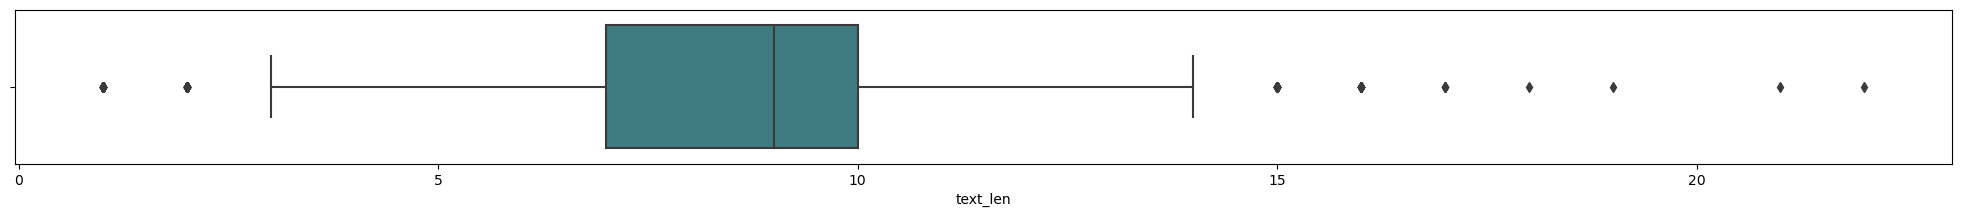

In [21]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)
print(data['text_len'].min())
print(data['text_len'].max())


fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")
plt.show()

In [27]:
print(data['text_len'].quantile(.01))
print(data['text_len'].quantile(.99))

15.0
305.52999999999884


In [29]:
len(data[data['text_len'] > 22])

0

### 3.5. Remove outliers based-on length of the sentences

<Axes: xlabel='text_len'>

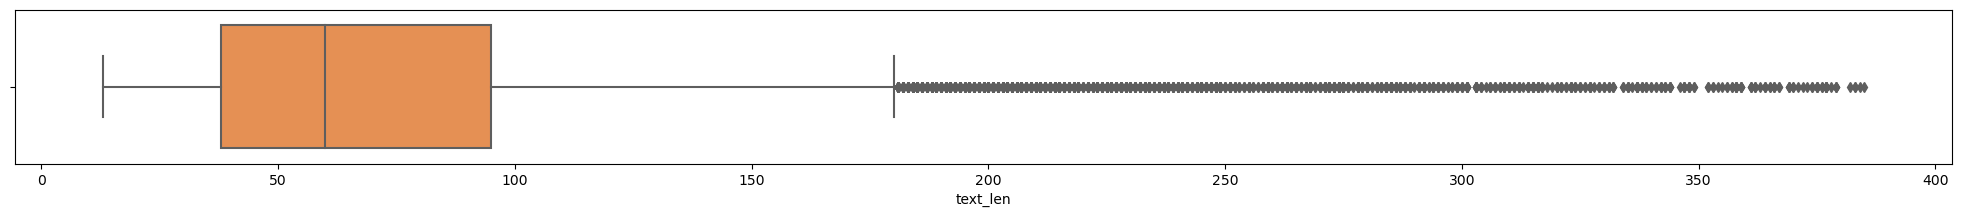

In [26]:
Q1 = data['text_len'].quantile(.01)
Q3 = data['text_len'].quantile(.99)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

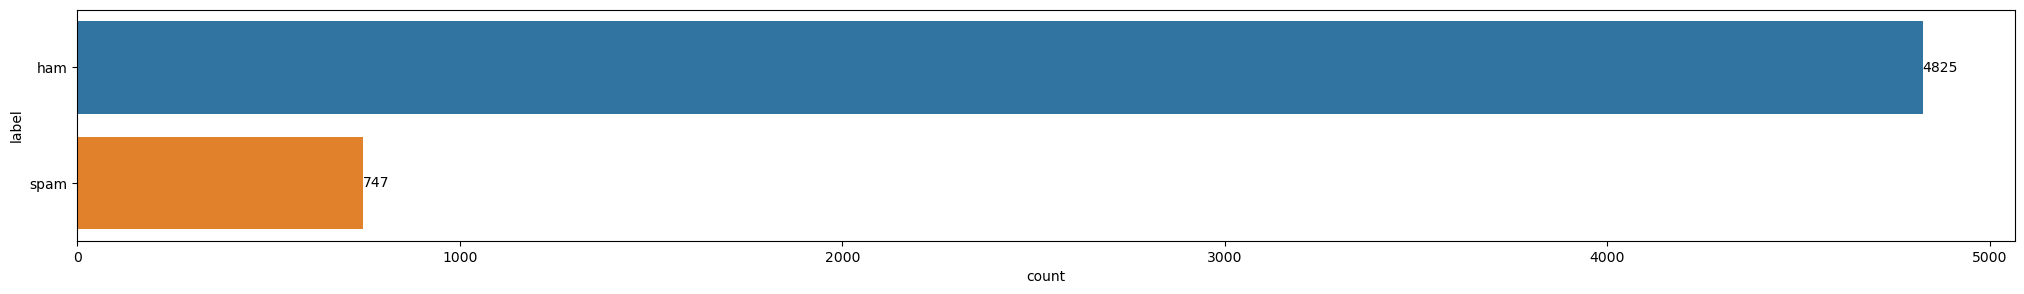

In [16]:
plt.subplots(figsize = (25,3))
ax = sns.countplot(data, y = data['label'])
ax.bar_label(ax.containers[0])
plt.show()

# 4. Preparing Dataset

In [37]:
LE = LabelEncoder()

X = data['clean_text']
# Y = LE.fit_transform(data['label']) ### For Classification Algoritms
# Y = pd.get_dummies(data['Sentiment']) ### For Deep Learning Algoritms
Y = data['Sentiment'] ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(5672,) (5672,)
(1601,) (1601,)
(809,) (809,)


In [39]:
vocab_size = 9754
embedding_dim = 128
max_length = 22
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
# num_label = y_train.shape[1]

In [ ]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

In [41]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

# Categorical Label
training_label = pd.get_dummies(training_label.reshape(-1)).values
testing_label = pd.get_dummies(testing_label.reshape(-1)).values
validating_label = pd.get_dummies(validating_label.reshape(-1)).values
num_label = training_label.shape[1]

print(training_padded.shape, training_label.shape)
print(testing_padded.shape, testing_label.shape)
print(validating_padded.shape, validating_label.shape)


9753
(3222, 22) (3222, 3)
(900, 22) (900, 3)
(465, 22) (465, 3)


# 5. Deep Learning Model

In [59]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(num_label, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(num_label, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.000_01)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 22, 128)           1248512   
                                                                 
 bidirectional_10 (Bidirecti  (None, 512)              592896    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 1,842,947
Trainable params: 1,842,947
Non-trainable params: 0
_________________________________________________________________


In [62]:
num_epoch = 20
batch_size = 32
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/20
101/101 [==============================] - 1s 11ms/step - loss: 0.8835 - accuracy: 0.6775 - val_loss: 0.9694 - val_accuracy: 0.5376
Epoch 2/20
101/101 [==============================] - 1s 11ms/step - loss: 0.8549 - accuracy: 0.7008 - val_loss: 0.9622 - val_accuracy: 0.5312
Epoch 3/20
101/101 [==============================] - 1s 11ms/step - loss: 0.8273 - accuracy: 0.7120 - val_loss: 0.9410 - val_accuracy: 0.5591
Epoch 4/20
101/101 [==============================] - 1s 10ms/step - loss: 0.8028 - accuracy: 0.7142 - val_loss: 0.9356 - val_accuracy: 0.5462
Epoch 5/20
101/101 [==============================] - 1s 10ms/step - loss: 0.7866 - accuracy: 0.7061 - val_loss: 1.0045 - val_accuracy: 0.5161
Epoch 6/20
101/101 [==============================] - 1s 9ms/step - loss: 0.7686 - accuracy: 0.7089 - val_loss: 0.9105 - val_accuracy: 0.5914
Epoch 7/20
101/101 [==============================] - 1s 9ms/step - loss: 0.7403 - accuracy: 0.7256 - val_loss: 0.9115 - val_accuracy: 0.6086
E

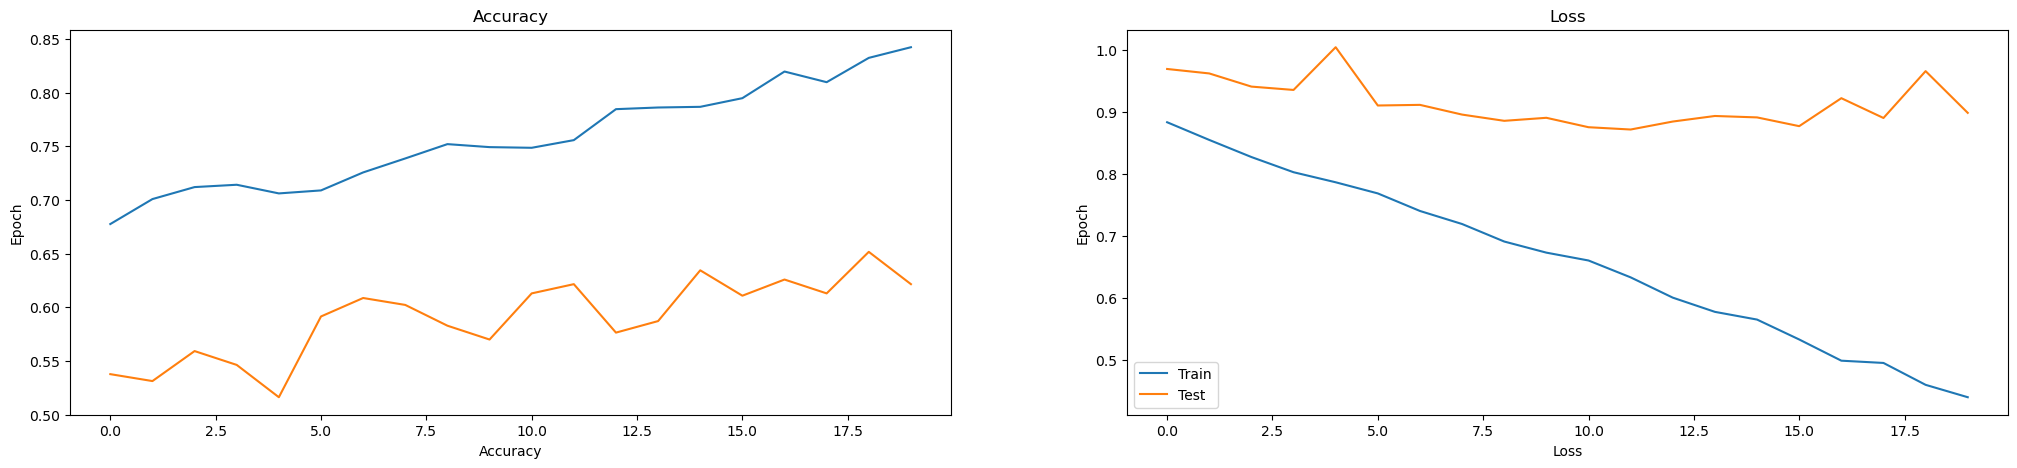

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [42]:
train_predictions = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals  Diff
0                  0        0  True
1                  0        0  True
2                  0        0  True
3                  0        0  True
4                  0        0  True


True     690
False     94
Name: Diff, dtype: int64

In [43]:
y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
print(classification_report(testing_label.argmax(axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       392
           1       0.91      0.84      0.88       392

    accuracy                           0.88       784
   macro avg       0.88      0.88      0.88       784
weighted avg       0.88      0.88      0.88       784



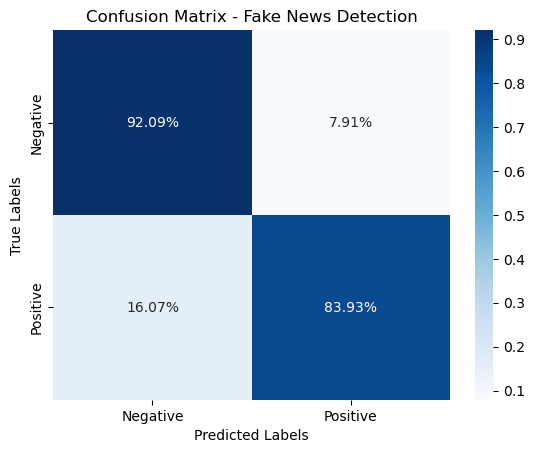

In [44]:
labels = y_train.columns

y_pred = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Classification Algoritms

In [63]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
linear = LinearRegression()
pac = PassiveAggressiveClassifier(random_state=42)

model = StackingClassifier([
    ('XGB', XGB),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('extraTres', extraTrees),
    ('knn', knn),
    ('decisionTree', decisionTree),
    # ('pac', pac),
    # ('linear', linear),
    # ('gradient', gradient),

], n_jobs=-1)

In [64]:
model.fit(training_padded, training_label)

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTres',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('knn', KNeighborsClassifier(n_jobs=-1)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       random_state=42))],
                   n_jobs=-1)

In [65]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(testing_label, y_pred), 2))

Train Score        : 100.0 %
Test Score         : 85.2 %
R Squared Error    : 0.41
Mean Squared Error : 0.15
Mean Absolute Error: 0.15


In [66]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals   Diff
0                  1        0  False
1                  1        0  False
2                  1        0  False
3                  0        0   True
4                  0        0   True


True     259
False     45
Name: Diff, dtype: int64

In [67]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       143
           1       0.88      0.83      0.86       161

    accuracy                           0.85       304
   macro avg       0.85      0.85      0.85       304
weighted avg       0.85      0.85      0.85       304



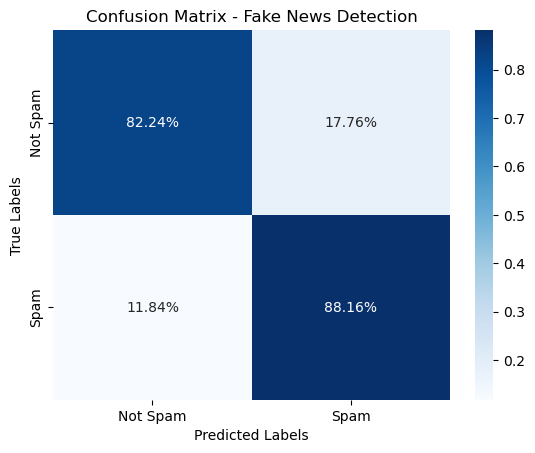

In [68]:
labels = ['Not Spam','Spam']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()